# American Options Demo (LSMC & Binomial)

This notebook demonstrates American option pricing with:

1. **Longstaff–Schwartz Monte Carlo (LSMC)**
2. **CRR Binomial Tree (American)**

It compares each method and shows simple convergence diagnostics.

## Setup
- The package should be importable as `options_pricing`.
- If running from the project root, ensure `src/` is on `PYTHONPATH`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os


# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)


from src.american import (
    american_lsmc, american_put_lsmc, american_call_lsmc,
    american_binomial, american_price,
)
from src.black_scholes import black_scholes_price

plt.rcParams["font.family"] = "Times New Roman"  # match project style

## Parameters

In [5]:
S = 100.0
K = 100.0
T = 1.0
r = 0.05
sigma = 0.20

np.set_printoptions(precision=6, suppress=True)

## Baselines: European prices (no early exercise)

In [6]:
eu_call = black_scholes_price(S, K, T, r, sigma, option_type="call")
eu_put  = black_scholes_price(S, K, T, r, sigma, option_type="put")
print(f"European Call (BS): {eu_call:.6f}")
print(f"European Put  (BS): {eu_put:.6f}")

European Call (BS): 10.450584
European Put  (BS): 5.573526


## American Call (no dividends): binomial should match European

In [7]:
am_call_bin = american_binomial(S, K, T, r, sigma, steps=800, option="call")
print(f"American Call (binomial, steps=800): {am_call_bin:.6f}")
print(f"Difference vs European: {am_call_bin - eu_call:+.6f}")

American Call (binomial, steps=800): 10.448084
Difference vs European: -0.002499


## American Put: LSMC vs Binomial

In [8]:
am_put_bin = american_binomial(S, K, T, r, sigma, steps=800, option="put")
am_put_lsm = american_put_lsmc(S, K, T, r, sigma, n_paths=80000, n_steps=75, seed=1)
print(f"American Put  (binomial, steps=800): {am_put_bin:.6f}")
print(f"American Put  (LSMC, 80k paths, 75 steps): {am_put_lsm:.6f}")
print(f"LSMC − Binomial: {am_put_lsm - am_put_bin:+.6f}")
print(f"American Put − European Put: {am_put_bin - eu_put:+.6f}")

American Put  (binomial, steps=800): 6.089402
American Put  (LSMC, 80k paths, 75 steps): 6.030882
LSMC − Binomial: -0.058519
American Put − European Put: +0.515876


## Convergence: Binomial steps → American put price

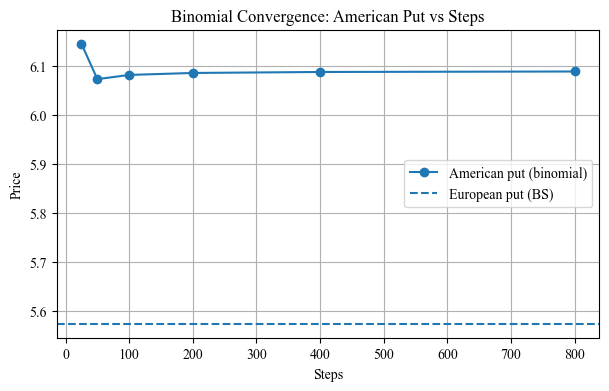

In [9]:
steps_list = [25, 50, 100, 200, 400, 800]
prices_bin = [american_binomial(S, K, T, r, sigma, steps=s, option="put") for s in steps_list]

plt.figure(figsize=(7,4))
plt.plot(steps_list, prices_bin, marker="o", label="American put (binomial)")
plt.axhline(eu_put, linestyle="--", label="European put (BS)")
plt.title("Binomial Convergence: American Put vs Steps")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Convergence: LSMC paths → American put price

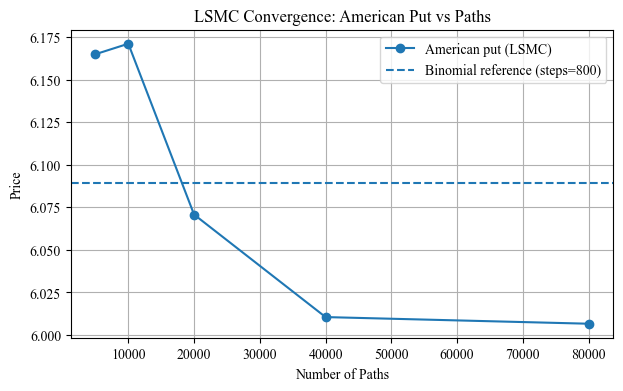

In [10]:
paths_list = [5_000, 10_000, 20_000, 40_000, 80_000]
prices_lsm = [american_put_lsmc(S, K, T, r, sigma, n_paths=n, n_steps=60, seed=1) for n in paths_list]

plt.figure(figsize=(7,4))
plt.plot(paths_list, prices_lsm, marker="o", label="American put (LSMC)")
plt.axhline(am_put_bin, linestyle="--", label="Binomial reference (steps=800)")
plt.title("LSMC Convergence: American Put vs Paths")
plt.xlabel("Number of Paths")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Unified interface examples

In [11]:
val_lsmc = american_price(S, K, T, r, sigma, method="lsmc", option="put", n_paths=20000, n_steps=50, seed=0)
val_bin  = american_price(S, K, T, r, sigma, method="binomial", option="put", steps=400)
val_lsmc, val_bin

(6.069671704751883, 6.088405897039063)

## Reproducibility check (LSMC with fixed seed)

In [12]:
v1 = american_call_lsmc(S, K, T, r, sigma, n_paths=50000, n_steps=50, seed=123)
v2 = american_call_lsmc(S, K, T, r, sigma, n_paths=50000, n_steps=50, seed=123)
print(v1, v2, "equal=", v1 == v2)

10.509333183310392 10.509333183310392 equal= True


### Notes
- For calls with **no dividends**, early exercise is not optimal, so American call = European call (shown above).
- For puts, American ≥ European; the difference widens with higher interest rates, higher volatility, and longer maturities.
- LSMC accuracy improves with more **paths**, more **exercise dates**, and richer **basis functions** (but costs more CPU).